In [11]:
import qiskit as qk
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile
from qiskit.visualization import plot_histogram
from math import pi
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import pandas as pd
import numpy as np
import random
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from time import time
from qiskit.circuit.library.standard_gates import RYGate, RYYGate

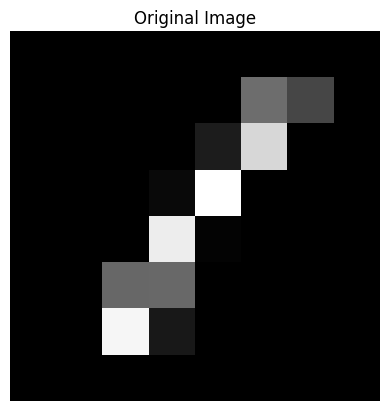

In [12]:
# Read the CSV file. 
# (Assuming the CSV has a label in the first column and pixel values in the remaining 64 columns, for an 8x8 image.)
dataset = pd.read_csv('../frqi/website/static/mnist_dataset.csv')

# Select the first image, ignoring the label column.
# Adjust slicing if your file has a different format.
image_data = dataset.to_numpy()[0, 1:]
# Reshape to an 8x8 array and ensure pixel values are integers (0-255)
image = image_data.reshape(8, 8).astype(np.uint8)

plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [20]:
# Normalize pixel values to 8-bit integers (0-255)
pixel_values = image.flatten()

# Declare the Quantum and Classical registers
position_qubits = QuantumRegister(6, 'pos')  # 6 qubits for 64 positions
intensity_qubits = QuantumRegister(8, 'int')  # 8 qubits for intensity (8-bit grayscale)
classical_bits = ClassicalRegister(14, 'c')  # For measurement
qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)

# Function to apply Hadamard gates to position qubits
def hadamard(circ, n):
    for i in n:
        circ.h(i)

def encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_vals):
    n = len(position_qubits)
    m = len(intensity_qubits)

    for idx, pixel in enumerate(pixel_vals):
        # big-endian index & intensity strings
        bin_idx       = format(idx,   f'0{n}b')  
        intensity_bin = format(pixel, f'0{m}b')

        # 1) “select” the basis state |idx⟩ by flipping pos-qubits where bit=0
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])

        # 2) for each ‘1’ in the intensity, apply an mcx onto the reversed qubit
        for j, bit in enumerate(intensity_bin):
            if bit == '1':
                circ.mcx(
                    control_qubits=position_qubits,
                    target_qubit=intensity_qubits[m - 1 - j]
                )

        # 3) uncompute the X’s so the pos-register is clean for the next idx
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])


# NEQR function to encode the image
def neqr(circ, position_qubits, intensity_qubits, pixel_values):
    # Apply Hadamard to position qubits to create superposition
    circ.h(position_qubits)
    # Encode pixel values
    encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_values)


# Apply NEQR encoding
neqr(qc, position_qubits, intensity_qubits, pixel_values)

# Measure all qubits
qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])

# Visualize the circuit
# qc.draw('mpl')

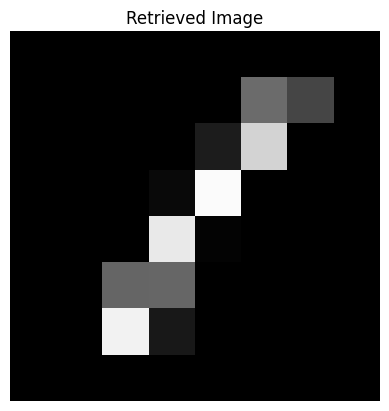

In [21]:
from collections import defaultdict
from qiskit import transpile
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# 1) Transpile & run
simulator = AerSimulator()
t_qc = transpile(qc, simulator)
result = simulator.run(t_qc, shots=180).result()
counts = result.get_counts()

# 2) Build a dict: position → { intensity → votes }
pos2counts = defaultdict(lambda: defaultdict(int))
for bitstr, cnt in counts.items():
    # MSB-first: first 8 bits = intensity, last 6 bits = position
    intensity = int(bitstr[:8],  2)
    position  = int(bitstr[8:],   2)
    pos2counts[position][intensity] += cnt

# 3) Winner-takes-all decode
flat = np.zeros(64, dtype=int)
for pos, idict in pos2counts.items():
    # pick the intensity with the highest vote-count
    flat[pos] = max(idict.items(), key=lambda kv: kv[1])[0]

# 4) Reshape back to 8×8 and plot
retrieve_image = flat.reshape((8,8)).astype(np.uint8)
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.title("Retrieved Image")
plt.axis('off')
plt.show()


In [22]:
from skimage.metrics import structural_similarity as ssim

def ssim_fidelity(original, retrieved):
    return ssim(original, retrieved, data_range=255)

In [23]:
from skimage.metrics import structural_similarity as ssim

def ssim_fidelity(original, retrieved):
    return ssim(original, retrieved, data_range=255)

fidelity_func = ssim_fidelity
metric_name = "SSIM"
print("Using SSIM for fidelity.")

Using SSIM for fidelity.


In [ ]:
simulator = AerSimulator()
shot_counts = np.arange(100, 2001, 100)  # Every 100 shots, up to 2000
batch_size = 20  # Number of images in the batch
start_index = 0    # Start index for the batch
end_index = start_index + batch_size

def fidelity_for_image_args(args):
    img_idx, shots = args
    image_data = dataset.to_numpy()[img_idx, 1:]
    image = image_data.reshape(8, 8).astype(np.uint8)
    pixel_values = image.flatten()
    position_qubits = QuantumRegister(6, 'pos')
    intensity_qubits = QuantumRegister(8, 'int')
    classical_bits = ClassicalRegister(14, 'c')
    qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)
    neqr(qc, position_qubits, intensity_qubits, pixel_values)
    qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])
    t_qc = transpile(qc, simulator)
    result = simulator.run(t_qc, shots=int(shots)).result()
    counts = result.get_counts()
    pos2counts = defaultdict(lambda: defaultdict(int))
    for bitstr, cnt in counts.items():
        intensity = int(bitstr[:8],  2)
        position  = int(bitstr[8:], 2)
        pos2counts[position][intensity] += cnt
    flat = np.zeros(64, dtype=int)
    for pos, idict in pos2counts.items():
        flat[pos] = max(idict.items(), key=lambda kv: kv[1])[0]
    retrieved_image = flat.reshape((8,8)).astype(np.uint8)
    fid = fidelity_func(image, retrieved_image)
    return fid

# Store results for CSV export
all_rows = [('ImageIndex', 'Shots', metric_name)]
fidelities = []  # mean for each shot count
stds = []        # std for each shot count
from concurrent.futures import ThreadPoolExecutor
for shots in shot_counts:
    print(f"Processing {shots} shots for batch of {batch_size} images...")
    args = [(img_idx, shots) for img_idx in range(start_index, end_index)]
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(fidelity_for_image_args, args))
    avg_fid = np.mean(results)
    std_fid = np.std(results)
    fidelities.append(avg_fid)
    stds.append(std_fid)
    for img_idx, fid in zip(range(start_index, end_index), results):
        all_rows.append((img_idx, shots, fid))
    print(f"Shots: {shots}, Avg {metric_name}: {avg_fid:.4f}, Std: {std_fid:.4f}")

Processing 100 shots for batch of 20 images...
Shots: 100, Avg SSIM: 0.7688, Std: 0.1557
Processing 151 shots for batch of 20 images...
Shots: 100, Avg SSIM: 0.7688, Std: 0.1557
Processing 151 shots for batch of 20 images...
Shots: 151, Avg SSIM: 0.9077, Std: 0.0979
Processing 227 shots for batch of 20 images...
Shots: 151, Avg SSIM: 0.9077, Std: 0.0979
Processing 227 shots for batch of 20 images...
Shots: 227, Avg SSIM: 0.9791, Std: 0.0282
Processing 342 shots for batch of 20 images...
Shots: 227, Avg SSIM: 0.9791, Std: 0.0282
Processing 342 shots for batch of 20 images...
Shots: 342, Avg SSIM: 0.9923, Std: 0.0214
Processing 515 shots for batch of 20 images...
Shots: 342, Avg SSIM: 0.9923, Std: 0.0214
Processing 515 shots for batch of 20 images...
Shots: 515, Avg SSIM: 1.0000, Std: 0.0000
Processing 776 shots for batch of 20 images...
Shots: 515, Avg SSIM: 1.0000, Std: 0.0000
Processing 776 shots for batch of 20 images...
Shots: 776, Avg SSIM: 1.0000, Std: 0.0000
Processing 1170 shots

Inverse power fit parameters: a=-16851.65205365291, b=-2.42809515660504, c=1.001968400916935


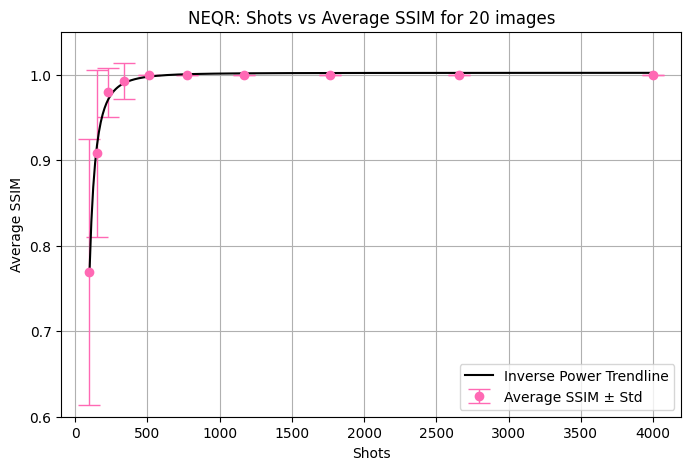

In [26]:
from scipy.optimize import curve_fit
import csv

def inverse_power(x, a, b, c):
    return a * np.power(x, b) + c

# Plot with error bars (std across images for each shot count)
plt.figure(figsize=(8,5))
plt.errorbar(shot_counts, fidelities, yerr=stds, fmt='o', capsize=8, elinewidth=1, color='hotpink', label=f'Average {metric_name} ± Std')
try:
    p0 = [1, -0.5, 0.5]
    params, _ = curve_fit(inverse_power, shot_counts, fidelities, p0, maxfev=20000)
    x_fit = np.linspace(min(shot_counts), max(shot_counts), 300)
    plt.plot(x_fit, inverse_power(x_fit, *params), color='black', linestyle='-', label='Inverse Power Trendline')
    print(f"Inverse power fit parameters: a={params[0]}, b={params[1]}, c={params[2]}")
except Exception as e:
    print("Inverse power fit failed:", e)

plt.title(f"NEQR: Shots vs Average {metric_name} for {batch_size} images")
plt.xlabel("Shots")
plt.ylabel(f"Average {metric_name}")
plt.grid(True)
plt.ylim(0.6, 1.05)
plt.legend()
plt.show()

# Option to save results as CSV
def save_csv(filename="neqr_batch_results_ssim.csv"):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(all_rows)
    print(f"Results saved to {filename}")

# Uncomment to save CSV
# save_csv()